In [1283]:
#pip install stable_baselines3

In [1284]:
import sys
sys.path.append("C:/Users/snr/kiam_rl")

import stable_baselines3
from rl_routines import RLProblem, Environment
from rl_routines import ActorCriticNetworks, get_CustomActorCriticPolicy
from rl_routines import evaluate_policy, statistics
import gymnasium as gym
import numpy
from numpy.linalg import norm
from stable_baselines3 import PPO
import torch
import math
import random
import matplotlib.pyplot as plt
import os
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
from torch.utils.tensorboard import SummaryWriter

In [1285]:
size = 1.0 # размер стороны квадрата-лабиринта
dV_max = 0.0009 # максимальный модуль приращения скорости агента
k1 = 5.0 # штраф за столкновение с препятствием или выход за пределы лабиринта
k2 = 9.0 # награда за достижение цели
k3 = 1.4 # награда за приближение к цели
k4 = 0.1 # штраф за каждый шаг (чтобы поощрить быстрое достижение цели)
num_obstacles = 0 # количество препятсвий
threshold = 0.05 # длина стенки квадрата-цели (выход)
total_timesteps = 100000 # общее количество шагов во время обучения модели

In [1286]:
class Circle:
    """
    Круги-препятсвия-астероиды
    """
    def __init__(self, x1, y1, radius):
        """
        Создание объект круга с заданными координатами центра (x1, y1) и радиусом radius
        """
        self.x1 = x1
        self.y1 = y1
        self.radius = radius

    def contains(self, point):
        """
        Проверка на то, находится ли точка внутри круга.
        """
        return math.sqrt((point[0] - self.x1) ** 2 + (point[1] - self.y1) ** 2) <= self.radius

class MazeProblem(RLProblem):
    """
    описание среды для обучения системы управления агентом в квадратном лабиринте с препятствиями
    """
    def __init__(self,  dV_max, threshold, k1, k2, k3, k4, num_obstacles, size: float, seed=None):
        super().__init__()
        self.tfinal = 1000.0
        self.nostep = 0  # Счётчик шагов (за эпизод)
        self.nsteps = 100 # Количество шагов (действий) агента за один эпизод
        self.size = size  # Размер квадратного лабиринта в км
        self.time_step = self.tfinal / self.nsteps  # Шаг по времени между действиями агента
        self.goal_position = numpy.array([self.size, self.size])
        self.x_old = None
        self.dV_max = dV_max  # максимальное приращение скорости в м/с
        self.threshold = threshold
        self.k1 = k1
        self.k2 = k2
        self.k3 = k3
        self.k4 = k4
        self.num_obstacles = num_obstacles
        self.obstacles = self.generate_obstacles(num_obstacles) #Генерация препятствий один раз при инициализации
        
    @property
    def observation_space(self):  # пространство наблюдений 
        return gym.spaces.Box(low=numpy.array([0., -1., -1., 0., 0., -numpy.inf, -numpy.inf]),
        high=numpy.array([self.size, 1., 1., self.size, self.size, numpy.inf, numpy.inf]),
        dtype=numpy.float64)

    @property
    def action_space(self):  # пространство действий
        return gym.spaces.Box(low=-1, high=1, shape=(2,), dtype=numpy.float32)

    def generate_obstacles(self, num_obstacles):
        """Генерируем круги-препятствия в квадрате."""
        obstacles = []
        while len(obstacles) < num_obstacles:
            radius = numpy.random.uniform(0.0007, 0.025)  
            x1 = numpy.random.uniform(radius, self.size - radius)
            y1 = numpy.random.uniform(radius, self.size - radius)
            new_circle = Circle(x1, y1, radius)
            # Проверяем на пересечение с существующими кругами
            if not any(self.circles_intersect(new_circle, existing_circle) for existing_circle in obstacles):
                obstacles.append(new_circle)
        return obstacles
    
    def circles_intersect(self, circle1, circle2):
        """
        Проверка пересечение двух кругов.
        Returns
        -------
        True/False
        """
        distance = numpy.linalg.norm(numpy.array([circle1.x1, circle1.y1]) - numpy.array([circle2.x1, circle2.y1]))
        return distance < (circle1.radius + circle2.radius)
    
    def initialize(self):
        """
        Инициализация начального положения из любой точки квадрата.
        Генерация начального состояния аппарата
        Returns
        -------
        t0 : float
            Начальный момент времени (обычно 0)
        x0 : np.ndarray, shape (4,)
            Начальный фазовый вектор (положение и скорость).
            Начальное положение выбирается из квадрата [0, size] x [0, size].
        """
        self.nostep = 0
        x0 = numpy.array([numpy.random.uniform(0, self.size),
                        numpy.random.uniform(0, self.size),
                        0., 0.])
        self.x_old = x0.copy()
        return 0.0, x0

    def closest_obstacle_distance(self, x):
        """Вычисляем расстояние до ближайшего круга и возвращаем также ближайший круг."""
        closest_distance = float('inf')
        closest_circle = None  # добавляем переменную для хранения ближайшего круга
        
        for obstacle in self.obstacles:
            distance_to_center = math.sqrt((x[0] - obstacle.x1) ** 2 + (x[1] - obstacle.y1) ** 2)
            distance_to_circle = distance_to_center - obstacle.radius
            if distance_to_circle < closest_distance:
                closest_distance = distance_to_circle
                closest_circle = obstacle  # сохраняем ссылку на текущий круг как ближайший
        return closest_distance, closest_circle  # возвращаем кортеж с расстоянием и объектом круга
    
    def action2u(self, action):
        """
        Функция, переводящая выход стратегии (нейросети) в импульс.
        Проверяет, что импульс удовлетворяет ограничениям.
        Возвращает импульс (в виде массива [dVx, dVy]).

        dV: float
            лежит в [-7.0; +7.0]

        """
        dV = numpy.clip(action * self.dV_max, -self.dV_max, self.dV_max)
        return dV

    def equations_of_motion(self, t, x):
        """
        Возвращает правую часть уравнений движения dx/dt = f(t, x, u)

        Parameters
        ----------
        t : float
            Текущий момент времени
        x : np.ndarray, shape(4,)
            Текущий фазовый вектор x = (r, v)
        
        Returns
        -------
        dx/dt(t, x) : np.ndarray, shape(4,)
            Правая часть уравнений.
            Импульсы тут НЕ учитываются
        """
        return numpy.array([x[2], x[3], 0., 0.])

    def check_trajectory_collision(self, x_old, x_new):
        """Проверяет, пересекает ли траектория отрезка (x_old -> x_new) какие-либо препятствия."""
        for obstacle in self.obstacles:
            # Координаты центра препятствия и его радиус
            cx, cy, r = obstacle.x1, obstacle.y1, obstacle.radius
            # Проверка пересечения отрезка с окружностью
            if self.segment_circle_intersect(x_old[:2], x_new[:2], (cx, cy), r):
                return True
        return False

    def segment_circle_intersect(self, p1, p2, center, radius):
        """Проверяет пересечение отрезка (p1 -> p2) с окружностью."""
        cx, cy = center
        # Вектор отрезка
        dx, dy = p2[0] - p1[0], p2[1] - p1[1]
        fx, fy = p1[0] - cx, p1[1] - cy

        # Квадрат расстояния от центра до прямой
        a = dx**2 + dy**2
        b = 2 * (fx * dx + fy * dy)
        c = fx**2 + fy**2 - radius**2

        # Дискриминант
        discriminant = b**2 - 4 * a * c
        if discriminant < 0:
            return False  # Нет пересечения

        discriminant = math.sqrt(discriminant)

        # Найти точки пересечения на прямой
        t1 = (-b - discriminant) / (2 * a)
        t2 = (-b + discriminant) / (2 * a)

        # Проверить, пересекают ли точки отрезок
        return 0 <= t1 <= 1 or 0 <= t2 <= 1

    def step(self, t, x, dV):
        """Шаг 'среды': агент сделал действие, получилось новое состояние."""
        self.x_old = x.copy()
        self.nostep += 1
        x_new = x.copy()
        x_new[2:4] += dV  # Учитываем импульс
        x_new = x_new + self.equations_of_motion(t, x_new) * self.time_step

        terminated = False
        truncated = False
        # Проверка пересечения траектории с препятствиями
        if self.check_trajectory_collision(self.x_old, x_new):
            #return t + self.time_step, x_new, False, True
                terminated = False
                truncated = True
              # Завершаем эпизод        

        # Условие достижения цели
        #if abs(x_new[0] - self.goal_position[0]) <= self.threshold and abs(x_new[1] - self.goal_position[1]) <= self.threshold:
        if (abs(x_new[0]) >= self.size - self.threshold) and (abs(x_new[1]) >= self.size - self.threshold):
            terminated = True  # Цель достигнута
        else:
            # Проверка выхода за границы квадрата или окончание времени
            if (x_new[0] < 0 or x_new[0] > self.size or x_new[1] < 0 or x_new[1] > self.size) or (self.nostep == self.nsteps):
                truncated = True

        # Завершаем эпизод при выполнении условия
        #if truncated or terminated:
            #return t + self.time_step, x_new, terminated, truncated
        
        # + условие на количество
        
        # Продолжаем движение
        return t + self.time_step, x_new, terminated, truncated

    def reward(self, t, x_new, dV, terminated, truncated):
        reward = 0

        distance_to_goal = norm(x_new[:2] - self.goal_position)
        previous_distance_to_goal = norm(self.x_old[:2] - self.goal_position)
        # Награда за приближение к цели
        #if distance_to_goal < previous_distance_to_goal:
        reward += self.k3 * (previous_distance_to_goal - distance_to_goal)

        # Штраф за каждый шаг (поощряет быстрое достижение цели)
        reward -= self.k4

        #Награда за достижение цели
        if terminated:
            reward += self.k2  # Значительная награда за достижение цели
            # print(reward)
            return reward
        # Штраф за столкновение с препятствием или выход за пределы
        if truncated and (not self.nostep == self.nsteps): # or self.check_trajectory_collision(self.x_old, x_new)
            reward -= self.k1
            # print(reward)
            return reward

        # print(reward)
        return reward


    def perception_model(self, t, x):  
        """Возвращает наблюдения: расстояние и единичный вектор направления к ближайшему препятствию"""
        # Проверка на ближайшую стенку
        size = self.size
        distances = {
            'left': x[0], 
            'right': size - x[0], 
            'top': size - x[1], 
            'bottom': x[1]
        }
        min_distance = min(distances.values())
        direction_to_wall = None
        if min_distance == distances['left']:
            direction_to_wall = (-1, 0)
        elif min_distance == distances['right']:
            direction_to_wall = (1, 0)
        elif min_distance == distances['top']:
            direction_to_wall = (0, 1)
        elif min_distance == distances['bottom']:
            direction_to_wall = (0, -1)
        # Проверка на ближайший круг
        closest_distance, closest_circle = self.closest_obstacle_distance(x[:2])
        # Сравниваем с расстоянием до стены
        if closest_distance < min_distance:
            direction_to_circle = (
                closest_circle.x1 - x[0],
                closest_circle.y1 - x[1]
            )
            phi = math.atan2(direction_to_circle[1], direction_to_circle[0])
            e = numpy.array([math.cos(phi), math.sin(phi)])  # единичный вектор направления к кругу
            return numpy.array([closest_distance, e[0], e[1], x[0], x[1], x[2], x[3]]) 
            
        else:
            # Если ближе стена, возвращаем направление к стене
            phi = math.atan2(direction_to_wall[1], direction_to_wall[0])
            direction_to_wall_unit = numpy.array([math.cos(phi), math.sin(phi)])  # единичный вектор к стене
            
            return numpy.array([min_distance, direction_to_wall_unit[0], direction_to_wall_unit[1], x[0], x[1], x[2], x[3]])

problem = MazeProblem(dV_max=dV_max, threshold=threshold, k1=k1, k2=k2, k3=k3, k4=k4, num_obstacles=num_obstacles, size=size)
env = DummyVecEnv([lambda: Monitor(Environment(problem))])

class MyActorCriticNetworks2(ActorCriticNetworks):
    def __init__(self, feature_dim):
        super().__init__(feature_dim, last_layer_dim_pi=2, last_layer_dim_vf=5)
        self.policy_net = torch.nn.Sequential( 
            torch.nn.Linear(7, 2),
            torch.nn.Tanh(),
        )
        self.value_net = torch.nn.Sequential(
            torch.nn.Linear(7, 5),
            torch.nn.Tanh(),
        )
MyActorCriticPolicy2 = get_CustomActorCriticPolicy(MyActorCriticNetworks2)

In [1287]:
model = PPO(MyActorCriticPolicy2,
            env,
            n_steps=1000,  
            batch_size=1000, 
            n_epochs=100, 
            learning_rate=0.001, 
            verbose=2,
            device='cuda',
            tensorboard_log='SpaceMaze_notebook',
            gamma=1.)

# Инициализация весов
# Функция для инициализации весов нулями
def initialize_weights_zeros(model):
    for m in model.policy.features_extractor.children():
        if isinstance(m, torch.nn.Linear):
            torch.nn.init.constant_(m.weight, 0.0)
            if m.bias is not None:
                torch.nn.init.constant_(m.bias, 0.0)
    print("Веса инициализированы нулями.")
init_choice = input("Выберите тип инициализации весов ('z' - нули, 'f' - из файла): ").strip().lower()
if init_choice == 'z':
    initialize_weights_zeros(model)
elif init_choice == 'f':
    weights_file = "C:/Users/snr/kiam_rl/train1.zip"
    if os.path.exists(weights_file):
        model = PPO.load("C:/Users/snr/kiam_rl/train1.zip", env=env)
        print(f"Веса загружены из {weights_file}.")
    else:
        print(f"Файл {weights_file} не найден. Используются стандартные начальные веса.")
else:
    print("Используются стандартные начальные веса.")

Using cpu device
Веса загружены из C:/Users/snr/kiam_rl/train1.zip.


In [1288]:
# Обучение модели
# model.learn(total_timesteps=total_timesteps)


In [1289]:
def my_statistics(x):
    q0 = numpy.quantile(x, 0.00)
    q1 = numpy.quantile(x, 0.10)
    q2 = numpy.quantile(x, 0.20)
    q3 = numpy.quantile(x, 0.30)
    q4 = numpy.quantile(x, 0.40)
    q5 = numpy.quantile(x, 0.50)
    q6 = numpy.quantile(x, 0.60)
    q7 = numpy.quantile(x, 0.70)
    q8 = numpy.quantile(x, 0.80)
    q9 = numpy.quantile(x, 0.90)
    q10 = numpy.quantile(x, 1.00)
    # mean = numpy.mean(x)
    # std = numpy.std(x)
    # cv = mean / std
    return q0, q1, q2, q3, q4, q5, q6, q7, q8, q9, q10 # , mean, std, cv

from stable_baselines3.common.evaluation import evaluate_policy
episode_rewards, episode_lengths = evaluate_policy(
    model, model.get_env(), n_eval_episodes=100, return_episode_rewards=True)

print(my_statistics(episode_rewards))

(-5.375428, 8.632033799999999, 8.670418999999999, 8.709313799999999, 8.762714, 8.814703999999999, 8.8792534, 8.955207, 9.0096062, 9.108044300000001, 9.292894)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


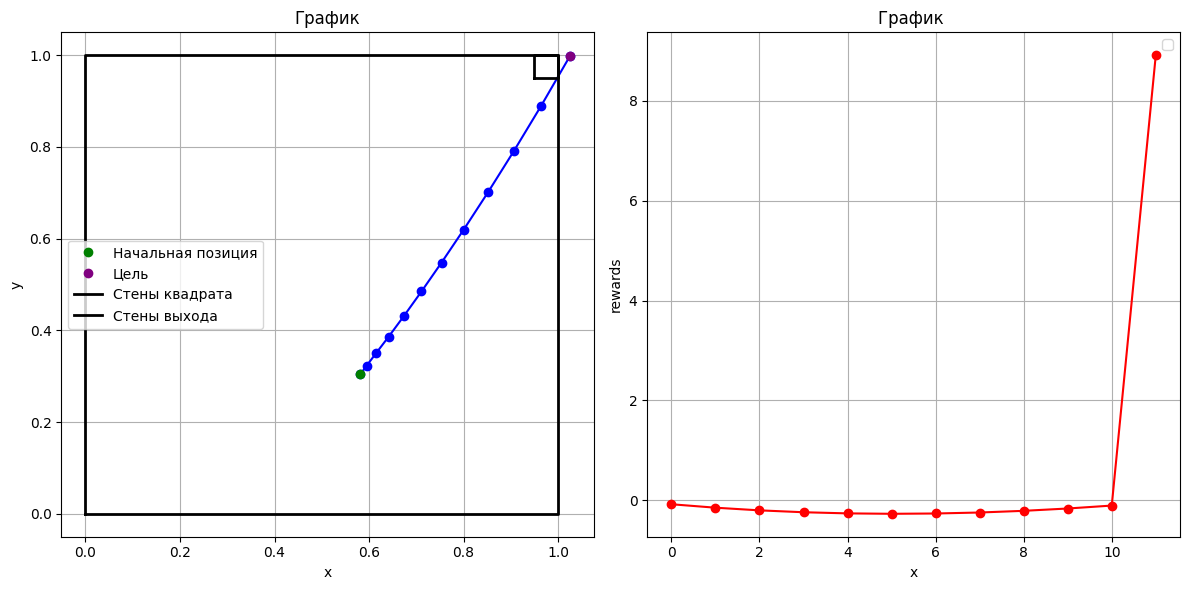

In [1290]:
vec_env = model.get_env()
obs = vec_env.reset()
action_array = []
states_array = []
obs_array = []
rewards_array = []
reward_total = 0
reward_total_array = []
for i in range(100):
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, dones, info = vec_env.step(action)
    # print(info[0])
    if dones[0]:
        obs_array.append(info[0]['terminal_observation'])
        rewards = numpy.array(info[0]['episode']['r'])
        reward_total_array.append(rewards)
        break
    reward_total += rewards
    obs_array.append(obs[0, :])
    rewards_array.append(rewards)
    reward_total_array.append(reward_total[0])
    action_array.append(action)
    states_array.append(_states)
action_array = numpy.array(action_array)
states_array = numpy.array(states_array)
obs_array = numpy.array(obs_array)
x_array = obs_array[:, -4]
y_array = obs_array[:, -3]


# Создание фигуры и осей  
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  

ax1.plot(x_array, y_array,'-o', color='blue', label='')  
ax1.plot(x_array[0], y_array[0], 'o', color="green", label="Начальная позиция")
ax1.plot(x_array[-1], y_array[-1], 'o', color="purple", label="Цель")
ax1.plot([0, size, size, 0, 0], [0, 0, size, size, 0], 'k-', linewidth=2, label="Стены квадрата")
ax1.plot([size - threshold, size, size, size - threshold, size - threshold], [size - threshold, size - threshold, size, size, size - threshold], 'k-', linewidth=2, label="Стены выхода")
ax1.set_title('График')  
ax1.set_xlabel('x')  
ax1.set_ylabel('y')  
ax1.legend()  
ax1.grid()  

ax2.plot(reward_total_array, '-o', color='red', label='')  
ax2.set_title('График ')  
ax2.set_xlabel('x')  
ax2.set_ylabel('rewards')  
ax2.legend()  
ax2.grid()  
  
plt.tight_layout()  
plt.show() 

In [1291]:
# save_choice = input("Сохранить обученные веса? ('y' - да, 'n' - нет): ").strip().lower()
# if save_choice == 'y':
#     save_path = "C:/Users/snr/kiam_rl/train1.zip"
#     model.save(save_path)
#     print(f"Модель сохранена в {save_path}.")
# else:
#     print("Сохранение пропущено.")

Склад

--------

In [1292]:

# Архитектура №1, 03.02.2025
# class MyActorCriticNetworks2(ActorCriticNetworks):
#     def __init__(self, feature_dim):
#         super().__init__(feature_dim, last_layer_dim_pi=2, last_layer_dim_vf=5)
#         self.policy_net = torch.nn.Sequential(
#             torch.nn.Linear(7, 64),
#             torch.nn.ReLU(),
#             torch.nn.Linear(64, 32),
#             torch.nn.ReLU(),
#             torch.nn.Linear(32, 2),
#             torch.nn.Tanh(),
#         )
#         self.value_net = torch.nn.Sequential(
#             torch.nn.Linear(7, 64),
#             torch.nn.ReLU(),
#             torch.nn.Linear(64, 32),
#             torch.nn.ReLU(),
#             torch.nn.Linear(32, 5),
#             torch.nn.Tanh(),
#         )
# MyActorCriticPolicy2 = get_CustomActorCriticPolicy(MyActorCriticNetworks2)